In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results_v4_one_head/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny. Trying to reduce it: v4, One Head. 255 Normalization. Weighted for Precision.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

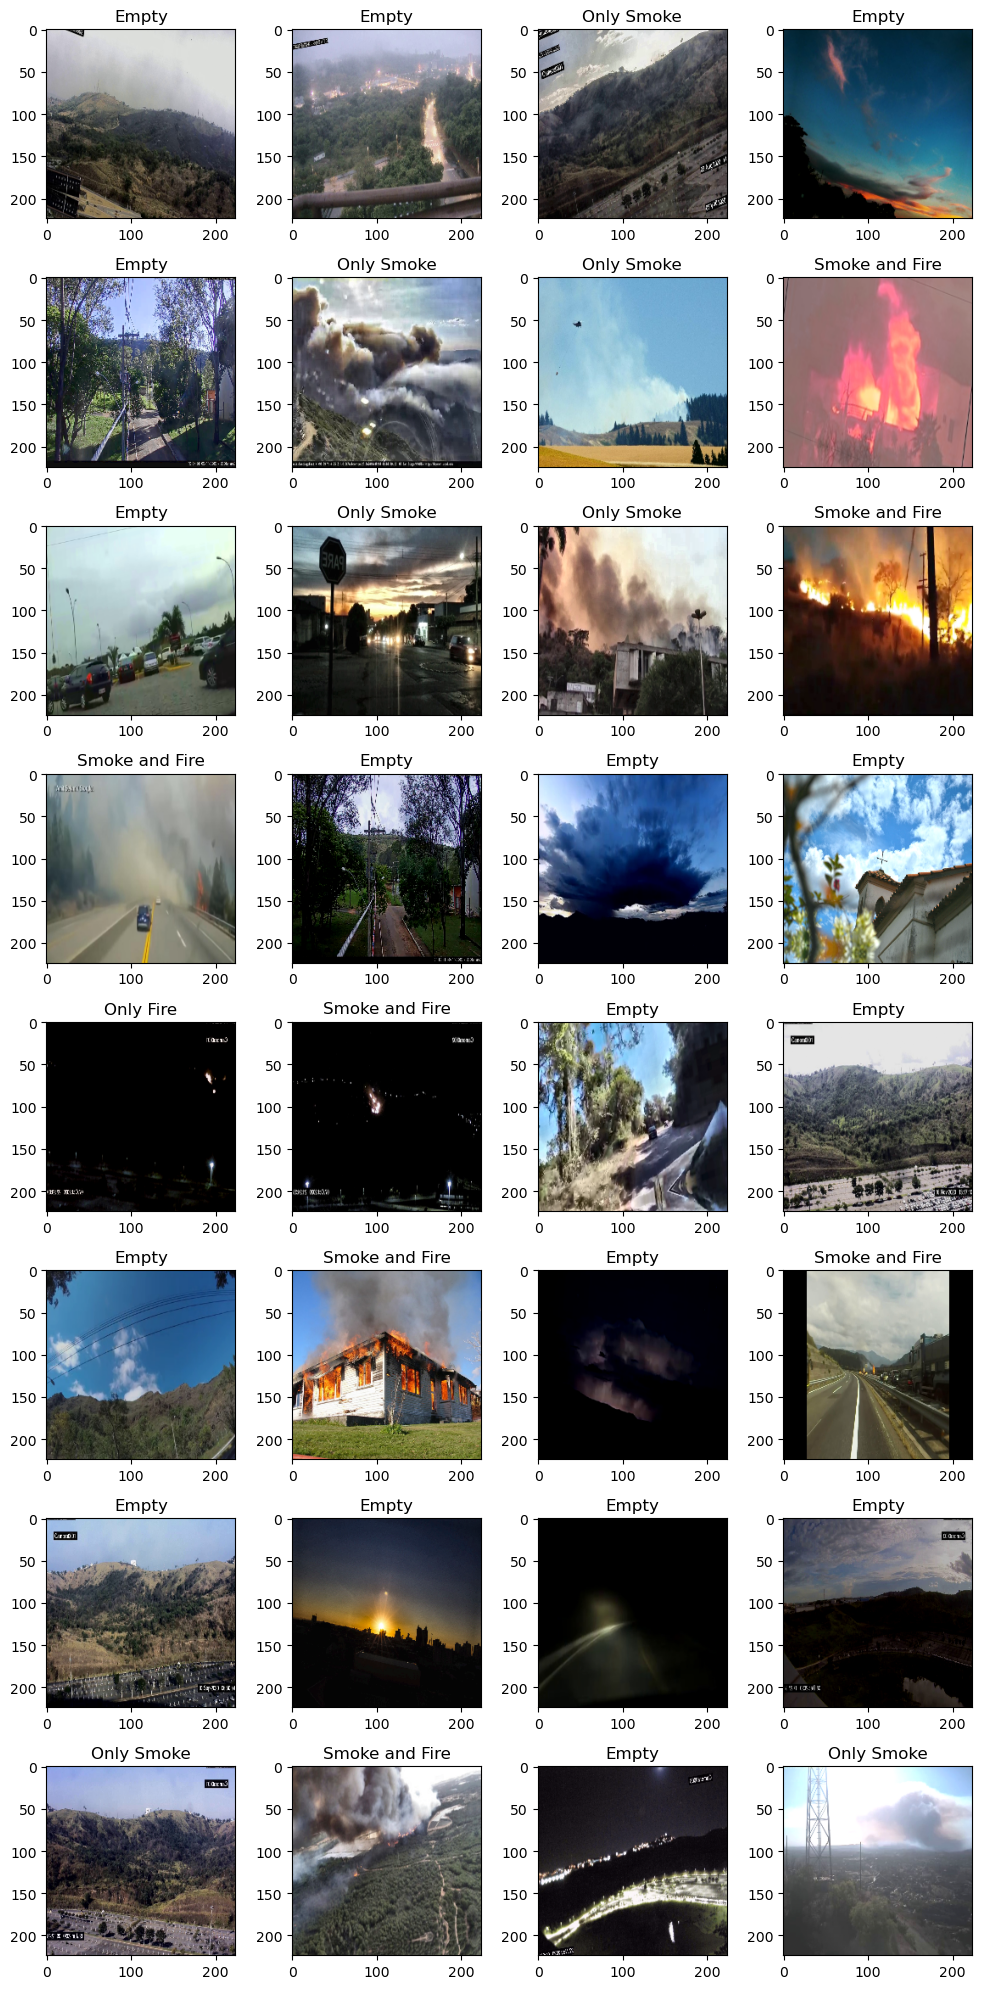

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: BED Less Layers

In [18]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(self.last_channels, affine=False),
            nn.ReLU(),

            # Output One Head, 2 Neurons
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(start_dim=1),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=2),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device, smoke_precision_weight):
        super(BCE_LOSS, self).__init__()
        self.smoke_precision_weight = smoke_precision_weight
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.pos_weight = torch.tensor([self.smoke_precision_weight]).to(self.device)
        self.bce_smoke = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=self.pos_weight)
        self.bce_fire = nn.BCEWithLogitsLoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce_smoke(predictions[..., 0],
                                    ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce_fire(predictions[..., 1],
                                  ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-3
EPOCHS = 125 #100
NUM_WORKERS = 8
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"

LOSS_FN = "BCE"
SMOKE_PRECISION_WEIGHT = 0.7

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [14]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [15]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [16]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [19]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[ 0.0694, -0.3250],
        [ 0.0864, -0.1948],
        [ 0.1135, -0.2290],
        [ 0.0837, -0.2255]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, mo

# Main Function

In [20]:
def main(model):

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        print(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        logger.info(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        loss_fn = BCE_LOSS(device=DEVICE, smoke_precision_weight=SMOKE_PRECISION_WEIGHT)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = torch.tensor([0.])
    smoke_f1_min_save = torch.tensor([0.9])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Weights already initialize in model call")
            logger.info("Weights already initialize in model call")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_' + MODEL + '_classifier.pt') 

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < v_pre[0].detach().to('cpu') ) and ( v_f1[0].detach().to('cpu') > smoke_f1_min_save ) :
            best_smoke_precision = v_pre[0].detach().to('cpu')
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_' + MODEL + '_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [ ]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_trained = main(model=model)

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE
Smoke Precision Weight: 0.7

***Start Training: 10:07:30

Initializing Weights

=== EPOCH 0/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
68.778      |36.585      |32.192      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.650      |36.400      |25.250      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.741 - F1: 0.000

Saving model with new best validation loss: 61.650

=== EPOCH 1/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.281      |36.069      |27.212      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.010      |35.604      |23.406      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.741 - Recall: 0.623 - Accuracy: 0.846 - F1: 0.677

Saving model with new best validation loss: 59.010

=== EPOCH 2/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.549      |35.676      |25.872      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.525      |35.120      |22.404      

SMOKE -> Precision: 0.591 - Recall: 0.274 - Accuracy: 0.560 - F1: 0.375
FIRE -> Precision: 0.733 - Recall: 0.644 - Accuracy: 0.847 - F1: 0.686

Saving model with new best validation loss: 57.525

=== EPOCH 3/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.269      |35.458      |24.811      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.793      |34.871      |21.923      

SMOKE -> Precision: 0.638 - Recall: 0.280 - Accuracy: 0.577 - F1: 0.389
FIRE -> Precision: 0.789 - Recall: 0.632 - Accuracy: 0.861 - F1: 0.702

Saving model with new best validation loss: 56.793

=== EPOCH 4/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.218      |35.131      |24.087      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.835      |35.062      |21.772      

SMOKE -> Precision: 0.648 - Recall: 0.288 - Accuracy: 0.582 - F1: 0.399
FIRE -> Precision: 0.804 - Recall: 0.622 - Accuracy: 0.863 - F1: 0.701

=== EPOCH 5/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.272      |34.897      |23.375      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.763      |34.117      |20.646      

SMOKE -> Precision: 0.668 - Recall: 0.371 - Accuracy: 0.609 - F1: 0.477
FIRE -> Precision: 0.737 - Recall: 0.711 - Accuracy: 0.859 - F1: 0.724

Saving model with new best validation loss: 54.763

=== EPOCH 6/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.019      |34.518      |22.501      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.147      |34.221      |19.926      

SMOKE -> Precision: 0.673 - Recall: 0.449 - Accuracy: 0.630 - F1: 0.539
FIRE -> Precision: 0.714 - Recall: 0.761 - Accuracy: 0.859 - F1: 0.737

Saving model with new best validation loss: 54.147

=== EPOCH 7/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.439      |34.373      |22.066      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.688      |34.629      |21.058      

SMOKE -> Precision: 0.667 - Recall: 0.318 - Accuracy: 0.595 - F1: 0.431
FIRE -> Precision: 0.812 - Recall: 0.620 - Accuracy: 0.865 - F1: 0.703

=== EPOCH 8/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.636      |34.071      |21.565      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.179      |33.529      |18.650      

SMOKE -> Precision: 0.681 - Recall: 0.411 - Accuracy: 0.624 - F1: 0.513
FIRE -> Precision: 0.768 - Recall: 0.744 - Accuracy: 0.876 - F1: 0.756

Saving model with new best validation loss: 52.179

=== EPOCH 9/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.895      |33.908      |20.988      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.572      |32.973      |19.599      

SMOKE -> Precision: 0.708 - Recall: 0.344 - Accuracy: 0.616 - F1: 0.463
FIRE -> Precision: 0.829 - Recall: 0.610 - Accuracy: 0.866 - F1: 0.703

=== EPOCH 10/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.094      |33.638      |20.456      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.272      |32.342      |17.930      

SMOKE -> Precision: 0.730 - Recall: 0.416 - Accuracy: 0.645 - F1: 0.530
FIRE -> Precision: 0.826 - Recall: 0.702 - Accuracy: 0.885 - F1: 0.759

Saving model with new best validation loss: 50.272

=== EPOCH 11/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.743      |33.482      |20.261      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.841      |32.184      |18.657      

SMOKE -> Precision: 0.721 - Recall: 0.561 - Accuracy: 0.684 - F1: 0.631
FIRE -> Precision: 0.726 - Recall: 0.859 - Accuracy: 0.880 - F1: 0.787

=== EPOCH 12/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.929      |33.085      |19.844      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.618      |32.001      |16.617      

SMOKE -> Precision: 0.716 - Recall: 0.457 - Accuracy: 0.652 - F1: 0.558
FIRE -> Precision: 0.792 - Recall: 0.798 - Accuracy: 0.893 - F1: 0.795

Saving model with new best validation loss: 48.618

=== EPOCH 13/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.214      |32.874      |19.340      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.106      |31.142      |16.964      

SMOKE -> Precision: 0.736 - Recall: 0.511 - Accuracy: 0.677 - F1: 0.603
FIRE -> Precision: 0.811 - Recall: 0.819 - Accuracy: 0.904 - F1: 0.815

Saving model with new best validation loss: 48.106

=== EPOCH 14/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.858      |32.796      |19.063      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.473      |31.235      |16.238      

SMOKE -> Precision: 0.751 - Recall: 0.444 - Accuracy: 0.662 - F1: 0.558
FIRE -> Precision: 0.870 - Recall: 0.710 - Accuracy: 0.897 - F1: 0.782

Saving model with new best validation loss: 47.473

=== EPOCH 15/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.926      |32.520      |18.405      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.926      |31.360      |16.567      

SMOKE -> Precision: 0.749 - Recall: 0.503 - Accuracy: 0.680 - F1: 0.602
FIRE -> Precision: 0.824 - Recall: 0.775 - Accuracy: 0.899 - F1: 0.799

=== EPOCH 16/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.643      |32.270      |18.373      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.943      |31.350      |15.593      

SMOKE -> Precision: 0.733 - Recall: 0.409 - Accuracy: 0.644 - F1: 0.525
FIRE -> Precision: 0.874 - Recall: 0.727 - Accuracy: 0.902 - F1: 0.794

Saving model with new best validation loss: 46.943

=== EPOCH 17/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.095      |32.183      |17.912      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.630      |30.230      |16.401      

SMOKE -> Precision: 0.764 - Recall: 0.514 - Accuracy: 0.690 - F1: 0.615
FIRE -> Precision: 0.832 - Recall: 0.761 - Accuracy: 0.898 - F1: 0.795

Saving model with new best validation loss: 46.630

=== EPOCH 18/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.914      |32.076      |17.838      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.751      |29.991      |14.760      

SMOKE -> Precision: 0.754 - Recall: 0.487 - Accuracy: 0.677 - F1: 0.591
FIRE -> Precision: 0.858 - Recall: 0.808 - Accuracy: 0.916 - F1: 0.832

Saving model with new best validation loss: 44.751

=== EPOCH 19/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.392      |31.835      |17.558      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.621      |29.500      |15.121      

SMOKE -> Precision: 0.766 - Recall: 0.514 - Accuracy: 0.691 - F1: 0.615
FIRE -> Precision: 0.866 - Recall: 0.795 - Accuracy: 0.915 - F1: 0.829

Saving model with new best validation loss: 44.621

=== EPOCH 20/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.161      |31.744      |17.417      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.231      |30.017      |15.214      

SMOKE -> Precision: 0.757 - Recall: 0.575 - Accuracy: 0.707 - F1: 0.654
FIRE -> Precision: 0.814 - Recall: 0.862 - Accuracy: 0.913 - F1: 0.838

=== EPOCH 21/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.818      |31.614      |17.204      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.312      |30.039      |14.273      

SMOKE -> Precision: 0.770 - Recall: 0.477 - Accuracy: 0.680 - F1: 0.589
FIRE -> Precision: 0.891 - Recall: 0.775 - Accuracy: 0.917 - F1: 0.829

Saving model with new best validation loss: 44.312

=== EPOCH 22/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.990      |31.426      |16.565      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.909      |29.059      |13.850      

SMOKE -> Precision: 0.770 - Recall: 0.546 - Accuracy: 0.703 - F1: 0.639
FIRE -> Precision: 0.847 - Recall: 0.844 - Accuracy: 0.920 - F1: 0.846

Saving model with new best validation loss: 42.909

=== EPOCH 23/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.665      |31.110      |16.556      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.930      |29.212      |14.718      

SMOKE -> Precision: 0.766 - Recall: 0.460 - Accuracy: 0.673 - F1: 0.575
FIRE -> Precision: 0.917 - Recall: 0.736 - Accuracy: 0.914 - F1: 0.817

=== EPOCH 24/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.297      |31.038      |16.259      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.535      |29.571      |13.965      

SMOKE -> Precision: 0.755 - Recall: 0.575 - Accuracy: 0.706 - F1: 0.653
FIRE -> Precision: 0.808 - Recall: 0.896 - Accuracy: 0.918 - F1: 0.850

=== EPOCH 25/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.682      |30.809      |15.873      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.422      |29.297      |13.126      

SMOKE -> Precision: 0.767 - Recall: 0.489 - Accuracy: 0.683 - F1: 0.597
FIRE -> Precision: 0.882 - Recall: 0.818 - Accuracy: 0.925 - F1: 0.849

Saving model with new best validation loss: 42.422

=== EPOCH 26/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.023      |30.877      |16.146      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.640      |29.858      |13.782      

SMOKE -> Precision: 0.763 - Recall: 0.422 - Accuracy: 0.659 - F1: 0.544
FIRE -> Precision: 0.925 - Recall: 0.757 - Accuracy: 0.921 - F1: 0.833

=== EPOCH 27/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.812      |30.730      |16.082      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.200      |29.884      |16.316      

SMOKE -> Precision: 0.782 - Recall: 0.412 - Accuracy: 0.662 - F1: 0.540
FIRE -> Precision: 0.945 - Recall: 0.663 - Accuracy: 0.903 - F1: 0.779

=== EPOCH 28/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.133      |30.439      |15.694      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.735      |28.219      |12.516      

SMOKE -> Precision: 0.805 - Recall: 0.516 - Accuracy: 0.707 - F1: 0.629
FIRE -> Precision: 0.896 - Recall: 0.815 - Accuracy: 0.928 - F1: 0.854

Saving model with new best validation loss: 40.735

=== EPOCH 29/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.790      |29.377      |15.413      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.906      |27.492      |14.415      

SMOKE -> Precision: 0.881 - Recall: 0.395 - Accuracy: 0.683 - F1: 0.545
FIRE -> Precision: 0.925 - Recall: 0.730 - Accuracy: 0.915 - F1: 0.816

=== EPOCH 30/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.577      |28.685      |14.893      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.497      |26.845      |12.652      

SMOKE -> Precision: 0.780 - Recall: 0.757 - Accuracy: 0.781 - F1: 0.768
FIRE -> Precision: 0.829 - Recall: 0.895 - Accuracy: 0.925 - F1: 0.860

Saving model with new best validation loss: 39.497

=== EPOCH 31/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.680      |27.944      |14.736      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.951      |25.622      |12.329      

SMOKE -> Precision: 0.778 - Recall: 0.839 - Accuracy: 0.807 - F1: 0.807
FIRE -> Precision: 0.831 - Recall: 0.919 - Accuracy: 0.931 - F1: 0.873

Saving model with new best validation loss: 37.951

=== EPOCH 32/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.104      |27.583      |14.521      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.816      |24.447      |11.368      

SMOKE -> Precision: 0.815 - Recall: 0.741 - Accuracy: 0.794 - F1: 0.776
FIRE -> Precision: 0.888 - Recall: 0.849 - Accuracy: 0.933 - F1: 0.868

Saving model with new best validation loss: 35.816

=== EPOCH 33/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.645      |27.189      |14.456      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.511      |23.445      |12.066      

SMOKE -> Precision: 0.818 - Recall: 0.764 - Accuracy: 0.805 - F1: 0.790
FIRE -> Precision: 0.886 - Recall: 0.826 - Accuracy: 0.927 - F1: 0.855

Saving model with new best validation loss: 35.511

=== EPOCH 34/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.375      |27.093      |14.282      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.279      |23.817      |12.461      

SMOKE -> Precision: 0.827 - Recall: 0.760 - Accuracy: 0.808 - F1: 0.792
FIRE -> Precision: 0.940 - Recall: 0.748 - Accuracy: 0.922 - F1: 0.833

=== EPOCH 35/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.943      |26.672      |14.271      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.142      |22.925      |11.217      

SMOKE -> Precision: 0.817 - Recall: 0.795 - Accuracy: 0.816 - F1: 0.806
FIRE -> Precision: 0.910 - Recall: 0.843 - Accuracy: 0.938 - F1: 0.875

Saving model with new best validation loss: 34.142

=== EPOCH 36/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.889      |26.131      |13.758      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.119      |22.863      |11.255      

SMOKE -> Precision: 0.799 - Recall: 0.852 - Accuracy: 0.826 - F1: 0.825
FIRE -> Precision: 0.905 - Recall: 0.837 - Accuracy: 0.935 - F1: 0.869

Saving model with new best validation loss: 34.119

=== EPOCH 37/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.067      |26.021      |14.046      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.291      |22.475      |10.816      

SMOKE -> Precision: 0.804 - Recall: 0.841 - Accuracy: 0.825 - F1: 0.822
FIRE -> Precision: 0.892 - Recall: 0.849 - Accuracy: 0.934 - F1: 0.870

Saving model with new best validation loss: 33.291

=== EPOCH 38/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.744      |25.692      |14.053      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.718      |21.694      |11.024      

SMOKE -> Precision: 0.817 - Recall: 0.847 - Accuracy: 0.835 - F1: 0.832
FIRE -> Precision: 0.931 - Recall: 0.816 - Accuracy: 0.937 - F1: 0.870

Saving model with new best validation loss: 32.718

=== EPOCH 39/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.359      |25.608      |13.752      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.887      |21.622      |11.265      

SMOKE -> Precision: 0.838 - Recall: 0.764 - Accuracy: 0.815 - F1: 0.799
FIRE -> Precision: 0.945 - Recall: 0.786 - Accuracy: 0.933 - F1: 0.858

=== EPOCH 40/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.958      |25.190      |13.768      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.503      |21.477      |12.027      

SMOKE -> Precision: 0.857 - Recall: 0.725 - Accuracy: 0.809 - F1: 0.786
FIRE -> Precision: 0.928 - Recall: 0.771 - Accuracy: 0.925 - F1: 0.843

=== EPOCH 41/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.572      |24.966      |13.606      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.506      |22.141      |11.365      

SMOKE -> Precision: 0.881 - Recall: 0.615 - Accuracy: 0.775 - F1: 0.724
FIRE -> Precision: 0.923 - Recall: 0.794 - Accuracy: 0.929 - F1: 0.853

=== EPOCH 42/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.615      |24.466      |13.149      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.225      |20.352      |10.873      

SMOKE -> Precision: 0.852 - Recall: 0.803 - Accuracy: 0.838 - F1: 0.827
FIRE -> Precision: 0.937 - Recall: 0.805 - Accuracy: 0.935 - F1: 0.866

Saving model with new best validation loss: 31.225

=== EPOCH 43/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.250      |24.237      |13.013      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.235      |20.415      |10.819      

SMOKE -> Precision: 0.885 - Recall: 0.696 - Accuracy: 0.810 - F1: 0.779
FIRE -> Precision: 0.938 - Recall: 0.806 - Accuracy: 0.936 - F1: 0.867

=== EPOCH 44/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.006      |23.935      |13.071      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.822      |19.765      |10.057      

SMOKE -> Precision: 0.864 - Recall: 0.754 - Accuracy: 0.825 - F1: 0.806
FIRE -> Precision: 0.880 - Recall: 0.876 - Accuracy: 0.937 - F1: 0.878

Saving model with new best validation loss: 29.822

=== EPOCH 45/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.509      |23.622      |12.887      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.054      |20.660      |11.394      

SMOKE -> Precision: 0.844 - Recall: 0.804 - Accuracy: 0.834 - F1: 0.823
FIRE -> Precision: 0.918 - Recall: 0.805 - Accuracy: 0.931 - F1: 0.858

=== EPOCH 46/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.984      |23.839      |13.145      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.631      |19.851      |10.780      

SMOKE -> Precision: 0.829 - Recall: 0.873 - Accuracy: 0.852 - F1: 0.850
FIRE -> Precision: 0.841 - Recall: 0.931 - Accuracy: 0.937 - F1: 0.884

=== EPOCH 47/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.315      |23.802      |12.513      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.999      |19.903      |10.097      

SMOKE -> Precision: 0.836 - Recall: 0.825 - Accuracy: 0.838 - F1: 0.830
FIRE -> Precision: 0.913 - Recall: 0.852 - Accuracy: 0.941 - F1: 0.882

=== EPOCH 48/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.766      |23.180      |12.586      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.613      |19.690      |9.923       

SMOKE -> Precision: 0.887 - Recall: 0.702 - Accuracy: 0.813 - F1: 0.784
FIRE -> Precision: 0.896 - Recall: 0.869 - Accuracy: 0.940 - F1: 0.882

Saving model with new best validation loss: 29.613

=== EPOCH 49/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.607      |22.880      |12.728      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.903      |19.264      |9.639       

SMOKE -> Precision: 0.875 - Recall: 0.730 - Accuracy: 0.820 - F1: 0.796
FIRE -> Precision: 0.937 - Recall: 0.843 - Accuracy: 0.945 - F1: 0.888

Saving model with new best validation loss: 28.903

=== EPOCH 50/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.841      |22.774      |12.068      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.255      |18.587      |9.668       

SMOKE -> Precision: 0.881 - Recall: 0.786 - Accuracy: 0.846 - F1: 0.831
FIRE -> Precision: 0.916 - Recall: 0.863 - Accuracy: 0.944 - F1: 0.889

Saving model with new best validation loss: 28.255

=== EPOCH 51/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.360      |22.895      |12.465      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.191      |18.572      |10.619      

SMOKE -> Precision: 0.870 - Recall: 0.783 - Accuracy: 0.840 - F1: 0.824
FIRE -> Precision: 0.939 - Recall: 0.817 - Accuracy: 0.939 - F1: 0.874

=== EPOCH 52/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.400      |22.323      |12.077      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.495      |19.090      |9.405       

SMOKE -> Precision: 0.867 - Recall: 0.786 - Accuracy: 0.839 - F1: 0.825
FIRE -> Precision: 0.911 - Recall: 0.865 - Accuracy: 0.943 - F1: 0.887

=== EPOCH 53/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.655      |22.479      |12.176      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.894      |18.508      |10.386      

SMOKE -> Precision: 0.847 - Recall: 0.853 - Accuracy: 0.855 - F1: 0.850
FIRE -> Precision: 0.957 - Recall: 0.809 - Accuracy: 0.941 - F1: 0.877

=== EPOCH 54/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.877      |21.966      |11.911      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.600      |17.267      |9.333       

SMOKE -> Precision: 0.885 - Recall: 0.807 - Accuracy: 0.856 - F1: 0.844
FIRE -> Precision: 0.933 - Recall: 0.851 - Accuracy: 0.946 - F1: 0.890

Saving model with new best validation loss: 26.600

=== EPOCH 55/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.686      |21.782      |11.904      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.123      |17.511      |9.612       

SMOKE -> Precision: 0.877 - Recall: 0.829 - Accuracy: 0.862 - F1: 0.853
FIRE -> Precision: 0.942 - Recall: 0.834 - Accuracy: 0.944 - F1: 0.885

=== EPOCH 56/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.867      |21.972      |11.895      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.647      |17.631      |10.015      

SMOKE -> Precision: 0.860 - Recall: 0.873 - Accuracy: 0.871 - F1: 0.866
FIRE -> Precision: 0.890 - Recall: 0.886 - Accuracy: 0.942 - F1: 0.888

=== EPOCH 57/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.250      |21.467      |11.782      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.528      |17.213      |9.315       

SMOKE -> Precision: 0.868 - Recall: 0.862 - Accuracy: 0.871 - F1: 0.865
FIRE -> Precision: 0.929 - Recall: 0.857 - Accuracy: 0.946 - F1: 0.891

Saving model with new best validation loss: 26.528

=== EPOCH 58/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.237      |21.540      |11.697      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.239      |17.583      |9.656       

SMOKE -> Precision: 0.853 - Recall: 0.862 - Accuracy: 0.862 - F1: 0.858
FIRE -> Precision: 0.917 - Recall: 0.859 - Accuracy: 0.943 - F1: 0.887

=== EPOCH 59/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.414      |20.984      |11.431      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.440      |17.722      |8.718       

SMOKE -> Precision: 0.904 - Recall: 0.776 - Accuracy: 0.852 - F1: 0.835
FIRE -> Precision: 0.908 - Recall: 0.901 - Accuracy: 0.951 - F1: 0.905

Saving model with new best validation loss: 26.440

=== EPOCH 60/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.667      |21.097      |11.570      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.207      |17.530      |10.677      

SMOKE -> Precision: 0.890 - Recall: 0.798 - Accuracy: 0.856 - F1: 0.842
FIRE -> Precision: 0.931 - Recall: 0.810 - Accuracy: 0.935 - F1: 0.866

=== EPOCH 61/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.933      |21.440      |11.493      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.922      |16.858      |9.064       

SMOKE -> Precision: 0.864 - Recall: 0.869 - Accuracy: 0.871 - F1: 0.866
FIRE -> Precision: 0.898 - Recall: 0.904 - Accuracy: 0.948 - F1: 0.901

Saving model with new best validation loss: 25.922

=== EPOCH 62/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.712      |21.068      |11.644      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.742      |17.251      |9.491       

SMOKE -> Precision: 0.895 - Recall: 0.791 - Accuracy: 0.855 - F1: 0.840
FIRE -> Precision: 0.944 - Recall: 0.849 - Accuracy: 0.948 - F1: 0.894

=== EPOCH 63/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.515      |20.943      |11.571      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.346      |16.752      |9.594       

SMOKE -> Precision: 0.905 - Recall: 0.805 - Accuracy: 0.865 - F1: 0.852
FIRE -> Precision: 0.938 - Recall: 0.838 - Accuracy: 0.944 - F1: 0.885

=== EPOCH 64/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.225      |20.842      |11.383      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.353      |18.642      |10.711      

SMOKE -> Precision: 0.918 - Recall: 0.699 - Accuracy: 0.825 - F1: 0.794
FIRE -> Precision: 0.958 - Recall: 0.797 - Accuracy: 0.938 - F1: 0.870

=== EPOCH 65/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.825      |20.625      |11.200      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.623      |16.685      |8.939       

SMOKE -> Precision: 0.877 - Recall: 0.829 - Accuracy: 0.862 - F1: 0.852
FIRE -> Precision: 0.892 - Recall: 0.898 - Accuracy: 0.945 - F1: 0.895

Saving model with new best validation loss: 25.623

=== EPOCH 66/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.443      |20.359      |11.084      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.750      |16.952      |8.799       

SMOKE -> Precision: 0.845 - Recall: 0.904 - Accuracy: 0.874 - F1: 0.873
FIRE -> Precision: 0.893 - Recall: 0.904 - Accuracy: 0.947 - F1: 0.898

=== EPOCH 67/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.069      |20.148      |10.921      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.183      |15.787      |9.397       

SMOKE -> Precision: 0.899 - Recall: 0.841 - Accuracy: 0.878 - F1: 0.870
FIRE -> Precision: 0.944 - Recall: 0.837 - Accuracy: 0.945 - F1: 0.887

Saving model with new best validation loss: 25.183

=== EPOCH 68/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.176      |20.274      |10.902      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.540      |16.263      |10.277      

SMOKE -> Precision: 0.906 - Recall: 0.808 - Accuracy: 0.867 - F1: 0.854
FIRE -> Precision: 0.952 - Recall: 0.802 - Accuracy: 0.938 - F1: 0.870

=== EPOCH 69/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.773      |19.961      |10.811      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.639      |16.219      |8.419       

SMOKE -> Precision: 0.854 - Recall: 0.903 - Accuracy: 0.879 - F1: 0.877
FIRE -> Precision: 0.919 - Recall: 0.897 - Accuracy: 0.953 - F1: 0.908

Saving model with new best validation loss: 24.639

=== EPOCH 70/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.764      |19.903      |10.861      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.775      |16.600      |9.175       

SMOKE -> Precision: 0.897 - Recall: 0.796 - Accuracy: 0.858 - F1: 0.843
FIRE -> Precision: 0.935 - Recall: 0.861 - Accuracy: 0.948 - F1: 0.896

=== EPOCH 71/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.241      |20.024      |11.217      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.927      |15.459      |9.467       

SMOKE -> Precision: 0.908 - Recall: 0.836 - Accuracy: 0.881 - F1: 0.871
FIRE -> Precision: 0.933 - Recall: 0.864 - Accuracy: 0.949 - F1: 0.897

=== EPOCH 72/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.591      |19.871      |10.720      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.361      |15.917      |8.444       

SMOKE -> Precision: 0.906 - Recall: 0.811 - Accuracy: 0.868 - F1: 0.856
FIRE -> Precision: 0.937 - Recall: 0.875 - Accuracy: 0.952 - F1: 0.905

Saving model with new best validation loss: 24.361

=== EPOCH 73/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.645      |20.000      |10.645      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.145      |15.555      |8.590       

SMOKE -> Precision: 0.892 - Recall: 0.834 - Accuracy: 0.871 - F1: 0.862
FIRE -> Precision: 0.925 - Recall: 0.884 - Accuracy: 0.951 - F1: 0.904

Saving model with new best validation loss: 24.145

=== EPOCH 74/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.961      |19.895      |11.066      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.356      |15.327      |9.029       

SMOKE -> Precision: 0.892 - Recall: 0.876 - Accuracy: 0.889 - F1: 0.884
FIRE -> Precision: 0.932 - Recall: 0.861 - Accuracy: 0.948 - F1: 0.895

=== EPOCH 75/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.803      |19.718      |11.085      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.145      |15.180      |8.966       

SMOKE -> Precision: 0.888 - Recall: 0.882 - Accuracy: 0.890 - F1: 0.885
FIRE -> Precision: 0.942 - Recall: 0.853 - Accuracy: 0.948 - F1: 0.896

=== EPOCH 76/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.451      |19.612      |10.838      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.565      |15.756      |8.809       

SMOKE -> Precision: 0.890 - Recall: 0.857 - Accuracy: 0.880 - F1: 0.873
FIRE -> Precision: 0.926 - Recall: 0.888 - Accuracy: 0.953 - F1: 0.907

=== EPOCH 77/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.251      |19.610      |10.641      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.534      |15.362      |9.172       

SMOKE -> Precision: 0.879 - Recall: 0.889 - Accuracy: 0.888 - F1: 0.884
FIRE -> Precision: 0.955 - Recall: 0.837 - Accuracy: 0.948 - F1: 0.892

=== EPOCH 78/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.718      |19.317      |10.400      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.780      |15.418      |8.362       

SMOKE -> Precision: 0.891 - Recall: 0.862 - Accuracy: 0.883 - F1: 0.876
FIRE -> Precision: 0.933 - Recall: 0.887 - Accuracy: 0.954 - F1: 0.910

Saving model with new best validation loss: 23.780

=== EPOCH 79/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.026      |19.421      |10.605      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.846      |16.473      |10.373      

SMOKE -> Precision: 0.933 - Recall: 0.751 - Accuracy: 0.854 - F1: 0.832
FIRE -> Precision: 0.956 - Recall: 0.800 - Accuracy: 0.939 - F1: 0.871

=== EPOCH 80/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.471      |19.113      |10.359      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.344      |14.664      |8.680       

SMOKE -> Precision: 0.894 - Recall: 0.874 - Accuracy: 0.890 - F1: 0.884
FIRE -> Precision: 0.941 - Recall: 0.859 - Accuracy: 0.949 - F1: 0.898

Saving model with new best validation loss: 23.344

=== EPOCH 81/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.582      |19.269      |10.313      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.398      |14.486      |8.912       

SMOKE -> Precision: 0.898 - Recall: 0.878 - Accuracy: 0.893 - F1: 0.888
FIRE -> Precision: 0.954 - Recall: 0.839 - Accuracy: 0.948 - F1: 0.893

=== EPOCH 82/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.575      |19.306      |10.269      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.628      |14.981      |8.647       

SMOKE -> Precision: 0.920 - Recall: 0.823 - Accuracy: 0.880 - F1: 0.869
FIRE -> Precision: 0.952 - Recall: 0.860 - Accuracy: 0.953 - F1: 0.904

=== EPOCH 83/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.189      |18.927      |10.262      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.316      |14.912      |8.404       

SMOKE -> Precision: 0.901 - Recall: 0.872 - Accuracy: 0.892 - F1: 0.886
FIRE -> Precision: 0.941 - Recall: 0.874 - Accuracy: 0.953 - F1: 0.906

Saving model with new best validation loss: 23.316

=== EPOCH 84/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.560      |18.828      |10.732      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.339      |14.763      |8.576       

SMOKE -> Precision: 0.897 - Recall: 0.869 - Accuracy: 0.889 - F1: 0.883
FIRE -> Precision: 0.926 - Recall: 0.870 - Accuracy: 0.948 - F1: 0.897

=== EPOCH 85/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.359      |19.110      |10.249      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.873      |14.857      |9.016       

SMOKE -> Precision: 0.901 - Recall: 0.871 - Accuracy: 0.892 - F1: 0.886
FIRE -> Precision: 0.949 - Recall: 0.834 - Accuracy: 0.945 - F1: 0.888

=== EPOCH 86/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.225      |18.728      |10.497      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.299      |14.707      |8.592       

SMOKE -> Precision: 0.883 - Recall: 0.910 - Accuracy: 0.899 - F1: 0.896
FIRE -> Precision: 0.934 - Recall: 0.865 - Accuracy: 0.949 - F1: 0.898

Saving model with new best validation loss: 23.299

=== EPOCH 87/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.956      |18.698      |10.259      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.316      |14.600      |8.716       

SMOKE -> Precision: 0.882 - Recall: 0.899 - Accuracy: 0.893 - F1: 0.890
FIRE -> Precision: 0.931 - Recall: 0.870 - Accuracy: 0.950 - F1: 0.899

=== EPOCH 88/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.841      |18.502      |10.339      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.618      |14.458      |8.160       

SMOKE -> Precision: 0.919 - Recall: 0.849 - Accuracy: 0.891 - F1: 0.883
FIRE -> Precision: 0.939 - Recall: 0.885 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 22.618

=== EPOCH 89/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.772      |18.770      |10.001      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.476      |14.626      |8.850       

SMOKE -> Precision: 0.885 - Recall: 0.893 - Accuracy: 0.893 - F1: 0.889
FIRE -> Precision: 0.957 - Recall: 0.843 - Accuracy: 0.950 - F1: 0.897

=== EPOCH 90/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.753      |18.514      |10.239      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.593      |14.514      |10.079      

SMOKE -> Precision: 0.915 - Recall: 0.846 - Accuracy: 0.888 - F1: 0.879
FIRE -> Precision: 0.956 - Recall: 0.820 - Accuracy: 0.944 - F1: 0.883

=== EPOCH 91/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.719      |18.704      |10.015      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.744      |15.103      |8.641       

SMOKE -> Precision: 0.871 - Recall: 0.921 - Accuracy: 0.896 - F1: 0.895
FIRE -> Precision: 0.919 - Recall: 0.895 - Accuracy: 0.952 - F1: 0.907

=== EPOCH 92/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.270      |18.348      |9.922       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.855      |14.939      |8.915       

SMOKE -> Precision: 0.908 - Recall: 0.827 - Accuracy: 0.877 - F1: 0.866
FIRE -> Precision: 0.947 - Recall: 0.849 - Accuracy: 0.948 - F1: 0.895

=== EPOCH 93/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.088      |18.142      |9.945       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.119      |13.909      |8.211       

SMOKE -> Precision: 0.904 - Recall: 0.876 - Accuracy: 0.896 - F1: 0.890
FIRE -> Precision: 0.934 - Recall: 0.886 - Accuracy: 0.954 - F1: 0.909

Saving model with new best validation loss: 22.119

=== EPOCH 94/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.089      |18.165      |9.924       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.513      |14.152      |8.361       

SMOKE -> Precision: 0.903 - Recall: 0.870 - Accuracy: 0.892 - F1: 0.886
FIRE -> Precision: 0.948 - Recall: 0.867 - Accuracy: 0.953 - F1: 0.905

=== EPOCH 95/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.200      |18.103      |10.098      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.951      |13.920      |8.031       

SMOKE -> Precision: 0.895 - Recall: 0.904 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.917 - Recall: 0.906 - Accuracy: 0.955 - F1: 0.912

Saving model with new best validation loss: 21.951

=== EPOCH 96/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.294      |18.324      |9.969       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.299      |14.860      |8.439       

SMOKE -> Precision: 0.878 - Recall: 0.928 - Accuracy: 0.903 - F1: 0.902
FIRE -> Precision: 0.916 - Recall: 0.886 - Accuracy: 0.950 - F1: 0.901

Saving model with new best smoke precision: 0.878

=== EPOCH 97/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.888      |18.057      |9.831       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.895      |13.557      |8.338       

SMOKE -> Precision: 0.909 - Recall: 0.888 - Accuracy: 0.903 - F1: 0.898
FIRE -> Precision: 0.946 - Recall: 0.863 - Accuracy: 0.952 - F1: 0.902

Saving model with new best validation loss: 21.895

=== EPOCH 98/124 ===
Learning Rate = 0.0002621440000000001



Training:  23%|███████▍                        | 63/269 [00:06<00:16, 12.74it/s]

# Plot Results

In [ ]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()